In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

In [3]:
data = pd.read_csv("../data/synthetic_slip_dataset_new.csv")

In [4]:
data.head()

,vehicle_speed,wheel_angular_velocity,wheel_torque,normal_force,tire_temp,steering_angle,slip_ratio
0,34.862115,116.481146,4.315105,3305.634551,49.065135,-0.387238,0.021460
1,16.362084,56.397715,68.768084,3183.636501,45.462923,-0.028244,0.001063
2,23.145478,89.779632,166.719619,2655.897096,35.776547,0.423526,0.179114
3,10.257165,35.681845,111.020621,2764.818850,38.834282,-0.467111,0.047028
4,22.064857,81.704850,324.859717,3842.336000,70.657348,-0.401569,0.120292


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x = data[["vehicle_speed", "wheel_angular_velocity", "wheel_torque", "normal_force", "tire_temp", "steering_angle"]]
y = data[["slip_ratio"]]

In [7]:
print(y)

       slip_ratio
0        0.021460
1        0.001063
2        0.179114
3        0.047028
4        0.120292
...           ...
19995    0.048237
19996    0.366072
19997    0.126029
19998    0.141362
19999    0.047734

[20000 rows x 1 columns]


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [9]:
train_data = x_train.join(y_train)
train_data.head()

,vehicle_speed,wheel_angular_velocity,wheel_torque,normal_force,tire_temp,steering_angle,slip_ratio
15722,35.950046,120.606075,9.729277,2458.462196,36.163585,0.256997,0.002522
6867,19.064567,66.533688,45.824699,2762.880792,38.164152,-0.129305,0.063328
16250,27.935917,123.543879,352.571137,2322.864266,28.131560,-0.226737,0.314395
15408,29.125557,99.099583,56.873222,3405.398416,55.481904,-0.494344,0.000731
19859,0.409951,1.455328,148.095096,3286.794609,55.870239,-0.281669,0.070511


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [11]:
scaler.fit(x_train)

,copy,True
,with_mean,True
,with_std,True


In [12]:
print("const int feature_count = ", len(scaler.mean_))

print("const float scaler_mean[] = {", end="")
print(*scaler.mean_, sep=', ', end="};\n")

print("const float scaler_scale[] = {", end="")
print(*scaler.scale_, sep=', ', end="};\n")

const int feature_count =  6
const float scaler_mean[] = {19.99087023604321, 78.9971939176289, 249.91221388044582, 2994.9817518729137, 44.89859439736129, -0.0016346375736175898};
const float scaler_scale[] = {11.543370927779709, 46.6256013686532, 144.71886510369237, 578.6243445821401, 15.041940606695075, 0.286855146946584};


In [13]:
model = models.Sequential([
    layers.Dense(24, input_shape=(6,)),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(12),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metrics.MeanAbsoluteError()]
)

/Users/aayanmapara/miniforge3/envs/ndtc/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-14 19:08:38.762803: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-14 19:08:38.763015: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-14 19:08:38.763028: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-14 19:08:38.763354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-14 19:08:38.763384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

In [14]:
history = model.fit(x_train_scaled, y_train, validation_data = (x_val_scaled, y_val), epochs=250, batch_size=32)

Epoch 1/250


2025-12-14 19:08:45.594387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1666 - mean_absolute_error: 0.1666 - val_loss: 0.0640 - val_mean_absolute_error: 0.0640
Epoch 2/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0579 - val_mean_absolute_error: 0.0579
Epoch 3/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0541 - mean_absolute_error: 0.0541 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437
Epoch 4/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0526 - mean_absolute_error: 0.0526 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 5/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0427 - val_mean_absolute_error: 0.0427
Epoch 6/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0418 - val_mean_absolute_error: 0.0418
Epoch 7/250
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0506 - mean_absolute_error: 0.0506 - val_lo

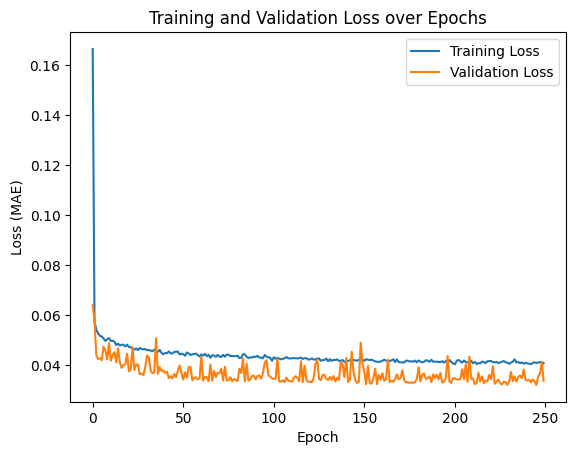

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733 (6.77 KB)

 Trainable params: 553 (2.16 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 1,108 (4.33 KB)

In [17]:
model.evaluate(x_test_scaled, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - mean_absolute_error: 0.0343


[0.03432915732264519, 0.03432915732264519]

In [18]:
preds = (model.predict(x_test_scaled))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
results_df = pd.DataFrame({'Actual Slip Ratio': y_test['slip_ratio'], 'Predicted Slip Ratio': preds.flatten()})
display(results_df)

,Actual Slip Ratio,Predicted Slip Ratio
11456,0.169332,0.179530
16528,0.276693,0.266178
3253,0.169801,0.233711
18614,0.343443,0.131626
1544,0.085568,0.072496
...,...,...
6375,0.158257,0.154240
14837,0.156884,0.175921
3931,0.382546,0.387156
18266,0.030451,0.008715


In [ ]:
model.save('slip_ratio_toy_model.h5')
print("Model saved to slip_ratio_toy_model.h5")

Model saved to slip_ratio_toy_model.h5


In [ ]:
model.save('slip_ratio_toy_model.keras')
print("Model saved to slip_ratio_toy_model.keras")

Model saved to slip_ratio_toy_model.keras


In [ ]:
import numpy as np
np.savez("scaler_values.npz", mean=scaler.mean_, scale=scaler.scale_)